In [1]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from gensim.models import KeyedVectors
%pip install pot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define parameters for Word2Vec model training
corpus_path = 'data/sv-en/euro.txt'  # Path to your corpus file
vector_size = 300  # Dimensionality of word vectors
window = 5  # Maximum distance between the current and predicted word within a sentence
min_count = 5  # Ignores all words with a total frequency lower than this
workers = 4  # Number of threads to use while training

# Load and preprocess the corpus
class MyCorpus:
    def __iter__(self):
        with open(corpus_path, 'r', encoding='utf-8') as file:
            for line in file:
                yield gensim.utils.simple_preprocess(line)

# Train the Word2Vec model
corpus = MyCorpus()
word2vec_model = gensim.models.Word2Vec(
    corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers
)

# Save the trained Word2Vec model
word2vec_model.save('models/word2vec_model_trained')  # Save the model for future use

In [3]:
# Load the trained Word2Vec model
word2vec_model_path = 'models/word2vec_model_trained'  # Path to your trained Word2Vec model
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_path)

def word_similarity(word1, word2, word_embeddings):
    if word1 in word_embeddings.wv.key_to_index and word2 in word_embeddings.wv.key_to_index:
        # If both words are in vocabulary, compute similarity
        vector1 = word_embeddings.wv[word1].reshape(1, -1)
        vector2 = word_embeddings.wv[word2].reshape(1, -1)
        similarity_score = cosine_similarity(vector1, vector2)[0][0]
        return similarity_score
    else:
        # If any word is not in vocabulary, return -1
        return -1

# Example usage
word1 = "odd"
word2 = "strange"
similarity_score = word_similarity(word1, word2, word2vec_model)
if similarity_score is not None:
    print("Cosine similarity score between '{}' and '{}': {:.4f}".format(word1, word2, similarity_score))
else:
    print("One or both words not found in vocabulary.")

Cosine similarity score between 'odd' and 'strange': 0.8188


In [5]:
# Read the SimLex-999 test set file
simlex_path = "data/SimLex-999/SimLex-999.txt"  # Replace with the actual path to your SimLex-999 file
simlex_data = []
with open(simlex_path, 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        line_data = line.strip().split("\t")
        simlex_data.append(line_data)


# Extract relevant columns (word1, word2, SimLex999)
word_pairs = [(row[0], row[1]) for row in simlex_data]
simlex_ratings = [float(row[3]) for row in simlex_data]
simlex_ratings = [rating for rating in simlex_ratings]
# Calculate similarity scores using your model
model_similarities = []
filtered_simlex_ratings = []  # To store ratings for pairs with valid similarity scores
for pair, rating in zip(word_pairs, simlex_ratings):
    word1, word2 = pair
    # Calculate similarity score using your model (replace this with your actual model code)
    similarity_score = word_similarity(word1, word2, word2vec_model)
    if similarity_score != -1:
        model_similarities.append(similarity_score * 10)
        filtered_simlex_ratings.append(rating)

# Evaluate the model
from scipy.stats import spearmanr
spearman_correlation, _ = spearmanr(filtered_simlex_ratings, model_similarities)
print("Spearman correlation between model predictions and SimLex-999 ratings:", spearman_correlation)


Spearman correlation between model predictions and SimLex-999 ratings: 0.2823628305677262


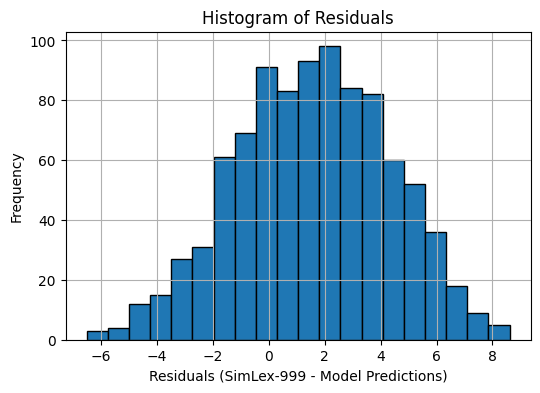

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Histogram of Residuals
residuals = [simlex_rating - model_similarity for simlex_rating, model_similarity in zip(filtered_simlex_ratings, model_similarities)]
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals (SimLex-999 - Model Predictions)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(filtered_simlex_ratings, model_similarities)
